<a href="https://colab.research.google.com/github/jlosar/Julio-Losa-ML-projeto/blob/main/MVP_Machine_Learning_%26_Analytics_Julio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics


*   Julio Cesar Losa Rodrigues
*   Matricula: 4052025001006
*   Dataset utilizado: Rossmann Store Sales (Kaggle)


# 1. Introdução:



*   **Objetivo:**

Fazer previsão de vendas futuras por loja e produto utilizando técnicas de Machine Learning.

*   **Descrição do problema**

Para qualquer gestor em uma empresa que trabalha com varejo fazer uma boa previsão do volume de vendas é condição fundamental para o planejamento do ano em relação a previsão de receita, Logística e investimento (verba para promoções, Mão de obra e etc.). Esse trabalho tem por objetivo tornar a previsão de vendas mais precisa, confiável e a força de vendas mais eficiênte.

*   **Descrição do Dataset:**

O dataset Rossmann Store Sales foi disponibilizado pelo Kaggle em uma competição de previsão de vendas. Ele contém informações de vendas diárias de 1.115 lojas da rede de farmácias Rossmann na Europa, durante o período de janeiro/2013 a julho/2015 (~2 anos e 7 meses).

*   **Desafios do Dataset:**

      1.   Alta variabilidade: vendas variam por loja, tipo, promoções e sazonalidade.
      2.   Dados faltantes: algumas lojas não possuem histórico completo de concorrência e promoções.
      3.   Fatores externos: datas especiais, feriados e promoções impactam fortemente as vendas.
      4.   Séries temporais múltiplas: mais de mil lojas diferentes, cada uma com comportamento próprio.








# 2. Carga e Preparação dos dados:

(treino, validação, teste; validação cruzada; sempre evitando vazamento de dados)

## Configurações iniciais, clonagem do repositório e carregamento dos dados

Inicialmente essa parte foi a mais dificultosa, pois estava baixando o dataset diretamente do kaggle sempre que iria rodar o arquivo. Bem instruído, consegui aprender a baixar para o Github.

O Arquivo "Train", pelo seu tamanho, dá uma complexidade maior em baixá-lo para o diretório do Github, pois eu tenho que utilizar Git LFS e tem vezes que esse caminho executa sem nenhum problema, outras ele demonstra erro.

In [53]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score)
from scipy.stats import randint, uniform
from IPython.display import display

# Configurações pandas
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# ======================
# Instalação Git LFS
# ======================
!apt-get install -q git-lfs
!git lfs install

# ======================
# Clonar repositório e carregar dados
# ======================
!rm -rf Julio-Losa-ML-projeto
!git clone https://github.com/jlosar/Julio-Losa-ML-projeto.git

!apt-get install git-lfs
!git lfs install
!git clone https://github.com/jlosar/Julio-Losa-ML-projeto.git
%cd Julio-Losa-ML-projeto
!git lfs pull
%cd ..

train = pd.read_csv("Julio-Losa-ML-projeto/Dados/train.csv")
test  = pd.read_csv("Julio-Losa-ML-projeto/Dados/test.csv")
store = pd.read_csv("Julio-Losa-ML-projeto/Dados/store.csv")

# ======================
# Verificação inicial
# ======================
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Store shape:", store.shape)

display(train.head())
display(test.head())
display(store.head())

Reading package lists...
Building dependency tree...
Reading state information...
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
Cloning into 'Julio-Losa-ML-projeto'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 14), reused 5 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 295.15 KiB | 1.79 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Encountered 2 file(s) that should have been pointers, but weren't:
	Dados/store.csv
	Dados/test.csv
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
fatal: destination path 'Julio-Losa-ML-projeto' already exists and is not an empty dire

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.00,1,0,0
1,2,3,4,2015-09-17,1.00,1,0,0
2,3,7,4,2015-09-17,1.00,1,0,0
3,4,8,4,2015-09-17,1.00,1,0,0
4,5,9,4,2015-09-17,1.00,1,0,0


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


## Descrição do dataset


In [54]:
#Informações sobre as vendas, o comportamento dos clientes e a frequência de promoções.

pd.set_option('display.float_format', lambda x: '%.2f' % x) #Comando para configurar o comportamento de exibição do Pandas.
store.describe() #função para identificar a distribuição dos dados, a presença de outliers ou valores discrepantes.

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00,1112.00,761.00,761.00,1115.00,571.00,571.00
mean,558.00,5404.90,7.22,2008.67,0.51,23.60,2011.76
std,322.02,7663.17,3.21,6.20,0.50,14.14,1.67
min,1.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,279.50,717.50,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,2325.00,8.00,2010.00,1.00,22.00,2012.00
75%,836.50,6882.50,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


In [55]:
store.isnull().sum()
    #".isnull()": É uma função que percorre cada célula do DataFrame e retorna True se a célula estiver vazia (nula) e False se contiver um valor.
    #".sum()": Soma o resultado de ".isnull()". Como Python trata True como 1 e False como 0, o .sum() simplesmente conta quantos valores nulos existem em cada coluna

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,3
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
Promo2,0
Promo2SinceWeek,544
Promo2SinceYear,544
PromoInterval,544


## Tratando a coluna "CompetitionDistance"

Irei útilizar a Média para preencher os dados das colunas vazias e com isso evitarei que o modelo superestime o impacto da concorrência para lojas sem dados  

In [56]:
# 1. Calcular a mediana da coluna
median_distance = store['CompetitionDistance'].median()

# 2. Preencher os valores ausentes com a mediana
store['CompetitionDistance'].fillna(median_distance, inplace=True)

# 3. Verificar o resultado para garantir que não há mais nulos
print(store['CompetitionDistance'].isnull().sum())

0


## Tratando as Colunas de Competição e de Promoção

O objetivo é transformá-las em uma única variável que capture a idade da concorrência.

In [57]:
# Seu código assume que df_store e df_train foram carregados assim:
# store = pd.read_csv('rossmann/store.csv')
# train = pd.read_csv('rossmann/train.csv')

# Preenchendo os valores nulos com valores seguros para cálculo de data.
store['CompetitionOpenSinceMonth'].fillna(1, inplace=True)
store['CompetitionOpenSinceYear'].fillna(1900, inplace=True)

# Garante que as colunas sejam do tipo inteiro.
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(int)
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(int)

# Preenche valores nulos com 0 ou 'NoPromo', indicando a ausência da promoção 2.
store['Promo2SinceWeek'].fillna(0, inplace=True)
store['Promo2SinceYear'].fillna(0, inplace=True)
store['PromoInterval'].fillna('NoPromo', inplace=True)

# Converte as colunas para o tipo inteiro.
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].astype(int)
store['Promo2SinceYear'] = store['Promo2SinceYear'].astype(int)

# Combina os dataframes de treino e loja em um único dataframe.
# Corrigido: Usando os nomes das suas variáveis
df_merged = pd.merge(train, store, on='Store', how='inner')

# Garante que a coluna de data esteja no formato correto.
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Cria a coluna de data de início da concorrência.
df_merged['CompetitionOpenSince'] = pd.to_datetime(
    df_merged['CompetitionOpenSinceYear'].astype(str) + '-' +
    df_merged['CompetitionOpenSinceMonth'].astype(str) + '-01',
    errors='coerce'
)

# Cria a coluna de data de início da Promoção 2.
df_merged['Promo2Start'] = df_merged.apply(
    lambda row: pd.to_datetime(
        f"{row['Promo2SinceYear']}-W{row['Promo2SinceWeek']}-1",
        format='%Y-W%W-%w', errors='coerce'
    ) if row['Promo2SinceYear'] > 0 else pd.NaT, axis=1
)

# Calcula a idade da concorrência em meses.
df_merged['CompetitionAgeInMonths'] = (
    (df_merged['Date'].dt.year - df_merged['CompetitionOpenSince'].dt.year) * 12 +
    (df_merged['Date'].dt.month - df_merged['CompetitionOpenSince'].dt.month)
)

# Calcula a idade da Promoção 2 em meses.
df_merged['Promo2AgeInMonths'] = (
    (df_merged['Date'].dt.year - df_merged['Promo2Start'].dt.year) * 12 +
    (df_merged['Date'].dt.month - df_merged['Promo2Start'].dt.month)
)

# Preenche valores inválidos ou negativos com 0 ou um valor seguro.
df_merged.loc[df_merged['CompetitionAgeInMonths'] < 0, 'CompetitionAgeInMonths'] = 0
df_merged['CompetitionAgeInMonths'].fillna(999, inplace=True)

df_merged.loc[df_merged['Promo2AgeInMonths'] < 0, 'Promo2AgeInMonths'] = 0
df_merged['Promo2AgeInMonths'].fillna(999, inplace=True)

# Remove as colunas originais que não são mais necessárias.
df_merged.drop(
    columns=[
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'CompetitionOpenSince',
        'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2Start'
    ],
    inplace=True
)

In [58]:
display(df_merged.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,CompetitionAgeInMonths,Promo2AgeInMonths
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,0,NoPromo,82,999.00
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,1,"Jan,Apr,Jul,Oct",92,64.00
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,1,"Jan,Apr,Jul,Oct",103,51.00
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,0,NoPromo,70,999.00
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,0,NoPromo,3,999.00


In [59]:
df_merged.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0


## Verificando a Existência de Outliers

In [60]:
# Função para contar outliers em uma coluna pelo método do IQR
def count_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Coluna: {column}")
    print(f" - Total de registros: {df.shape[0]}")
    print(f" - Outliers encontrados: {outliers.shape[0]} ({100*outliers.shape[0]/df.shape[0]:.2f}%)")
    print(f" - Limite inferior: {lower_bound:.2f}, Limite superior: {upper_bound:.2f}")
    print("="*50)
    return outliers

# Verificando em Sales e Customers
outliers_sales = count_outliers_iqr(df_merged, 'Sales')
outliers_customers = count_outliers_iqr(df_merged, 'Customers')

Coluna: Sales
 - Total de registros: 1017209
 - Outliers encontrados: 26694 (2.62%)
 - Limite inferior: -2466.50, Limite superior: 14049.50
Coluna: Customers
 - Total de registros: 1017209
 - Outliers encontrados: 38095 (3.75%)
 - Limite inferior: -243.00, Limite superior: 1485.00


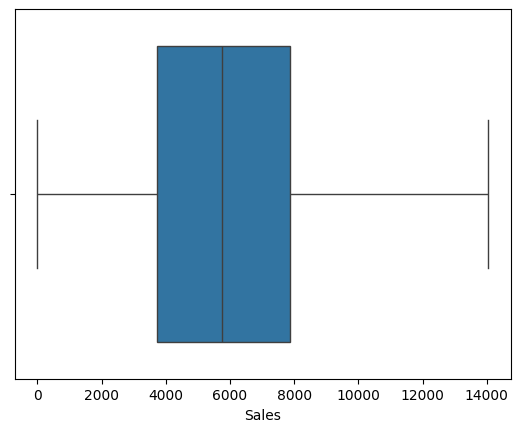

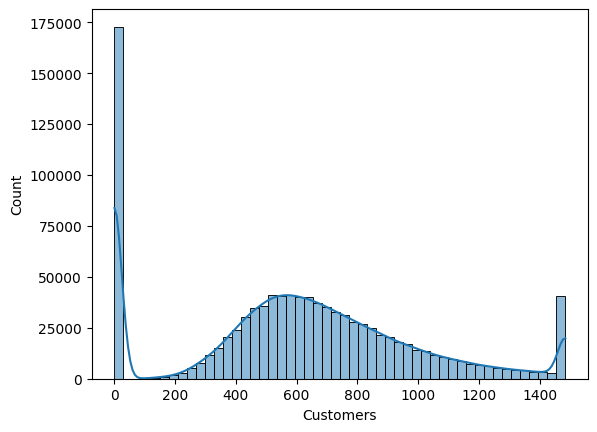

In [69]:
## Observação gráfica de como está se distribuindo os outliers no dataset.

# Boxplot de vendas
sns.boxplot(x=df_merged['Sales'])
plt.show()

# Histograma de clientes
sns.histplot(df_merged['Customers'], bins=50, kde=True)
plt.show()

## Tratando os outliers do dataset

Tratar outliers nesse dataset é importante porque esses valores extremos distorcem a distribuição das variáveis, prejudicam a performance e a interpretação de modelos de machine learning, especialmente os mais sensíveis a escala e variância dos dados.


Optei por tratar os outliers de Sales e Customers utilizando três etapas:

(i) exclusão de registros inconsistentes (Sales = 0 em lojas abertas)

(ii) Winsorization, limitando valores extremos fora do intervalo interquartílico (IQR).
Essa abordagem foi escolhida por equilibrar robustez estatística e preservação da variabilidade natural dos dados.

(iii) Transformação logarítmica (boa para Sales)

In [70]:
## Tratando os outliers:

# Exclusão de registros inconsistentes: Loja aberta e com venda = 0
df_merged = df_merged[~((df_merged['Open'] == 1) & (df_merged['Sales'] == 0))]

# Winsorization (tirando os outliers): Vamos limitar os valores extremos para que não distorçam o modelo.
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # limite inferior para a identificação de outliers. Valores abaixo desse limite são considerados outliers.
    upper_bound = Q3 + 1.5 * IQR #limite superior. Valores acima desse limite são considerados outliers.

    df[column] = np.where(df[column] < lower_bound, lower_bound, #verifica se o valor atual é menor que o limite inferior. Se for verdade, ele é substituído pelo "lower_bound".
                 np.where(df[column] > upper_bound, upper_bound, df[column])) #verifica se o valor é maior que o limite superior. Se for verdade, ele é substituído pelo "upper_bound".
    return df #Retorna o dataframe modificado, com os valores extremos limitados pelos "lower_bound" e "upper_bound".

df_merged = cap_outliers(df_merged, 'Sales') #Aplicação de Winsorização na coluna 'Sales'.
df_merged = cap_outliers(df_merged, 'Customers') #Aplica a Winsorização à coluna 'Customers'.

# Criando variável transformada
df_merged['Sales_log'] = np.log1p(df_merged['Sales'])


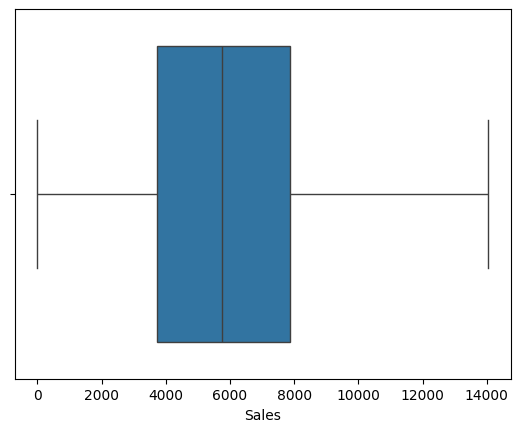

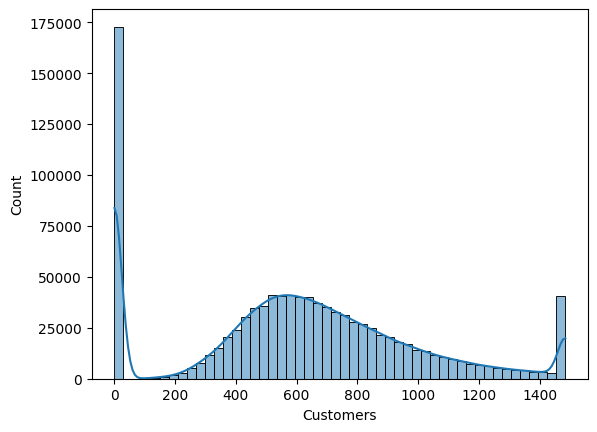

In [71]:
# Boxplot de vendas
sns.boxplot(x=df_merged['Sales'])
plt.show()
## Visualizar outliers


# Histograma de clientes
sns.histplot(df_merged['Customers'], bins=50, kde=True)
plt.show()

## Verificação se todos os outliers foram tratados

In [68]:
# Função para contar outliers em uma coluna pelo método do IQR
def count_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Coluna: {column}")
    print(f" - Total de registros: {df.shape[0]}")
    print(f" - Outliers encontrados: {outliers.shape[0]} ({100*outliers.shape[0]/df.shape[0]:.2f}%)")
    print(f" - Limite inferior: {lower_bound:.2f}, Limite superior: {upper_bound:.2f}")
    print("="*50)
    return outliers

# Verificando em Sales e Customers
outliers_sales = count_outliers_iqr(df_merged, 'Sales')
outliers_customers = count_outliers_iqr(df_merged, 'Customers')

Coluna: Sales
 - Total de registros: 1017155
 - Outliers encontrados: 0 (0.00%)
 - Limite inferior: -2464.00, Limite superior: 14048.00
Coluna: Customers
 - Total de registros: 1017155
 - Outliers encontrados: 0 (0.00%)
 - Limite inferior: -243.00, Limite superior: 1485.00


## Encoding de variáveis categóricas:

Os modelos de Machine Learning não entendem texto.
Eles precisam que variáveis categóricas sejam transformadas em números.

Optei por utilizar "One-Hot Encoding". Essa técnica cria colunas binárias para representar cada categoria, permitindo que os modelos interpretem a informação sem assumir relações ordinais inexistentes.
Optou-se por essa abordagem porque o dataset Rossmann possui categorias nominais, e o uso de One-Hot Encoding garante melhor interpretabilidade e compatibilidade com modelos lineares e baseados em árvores.

In [72]:
# Verificar quais colunas são categóricas
cat_cols = df_merged.select_dtypes(include=['object']).columns
print("Variáveis categóricas:", cat_cols)

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_merged, columns=cat_cols, drop_first=True)

Variáveis categóricas: Index(['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], dtype='object')


# 3. ⁠Divisão dos dados:

Limpeza, transformação, seleção/extração de atributos, engenharia de atributos, etc.

# 4. ⁠Modelagem:

treinar e comparar abordagens e modelos diferentes; quando possível, usar pipelines reproduzíveis.

# 5. ⁠Otimização de hiperparâmetros:

Explorar ajustes relevantes para cada modelo.

# 6. Avaliação:

Utilizar métricas adequadas ao tipo de problema, comparar modelos e discutir limitações e melhorias.

# 7. Boas práticas:

Estabelecer baseline, fixar seeds para reprodutibilidade, relatar recursos computacionais usados e tempo de treino, e documentar as decisões de projeto.